# Sprint 16.1.
## Entrega d'exercici: Pipelines, grid search i text mining

Comencem a familiaritzar-nos amb Pipelines, grid search i text mining !!! 

Comencem amb uns quants exercicis bàsics

# Nivell 1
## Exercici 1

Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.




## 1. Carga de librerías y archivos.

Para este ejercicio, voy a utilzar un dataset sobre precios de taxis. El dataset pertenece al challenge [Cab Fare Prediction] de la plataforma dockship.io y tienen como objetivo predecir la tarifa a partir de los datos existentes.

Para no extenderme mucho en el ejercicio haré un análisis exploratorio de las siguientes variables y muestrearé un 10% del dataset para aplicar el modelo predictivo.

[Cab Fare Prediction]: https://dockship.io/challenges/6006ba605c9276402bd77d96/cab-fare-prediction-ai-challenge/overview

In [1]:
# Libraries
#-----------------------------

# Data wrangling
#-----------------------------

import numpy as np
import pandas as pd

# Data Visualization
#-----------------------------

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Regression
#-----------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# File management
#--------------------------------------------------
from joblib import dump, load


In [2]:
# Data ingesting
train=pd.read_csv('./datasets/train.csv')

### 1.1. Exploración inicial del dataset, duplicados y valores nulos.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             100000 non-null  int64  
 1   time_stamp        100000 non-null  int64  
 2   cab_provider      100000 non-null  object 
 3   source            100000 non-null  object 
 4   destination       100000 non-null  object 
 5   distance          100000 non-null  float64
 6   surge_multiplier  100000 non-null  float64
 7   cab_type          100000 non-null  object 
 8   fare              100000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


In [4]:
train.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,0,1543203646318,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0
1,1,1543203646319,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,2,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
3,3,1543203646320,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5
4,4,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0


In [5]:
# Checking duplicated rows.
train.duplicated().sum()

0

In [6]:
# Checking missing values.
train.isna().sum().sum()

0


Tenemos un dataset con 100.000 observaciones con ocho variables. Tres de las variables son numéricas, cuatro categóricas y una variable de fecha en mili segundos.

El conjunto no tiene duplicados ni valores nulos.

## 2. Análisis exploratorio de los datos.
### 2.1. Análisis estadístico de las variables.

Voy a visualizar la distribución de las variables del dataset.

In [7]:
# Droping index column
train.drop(columns='index',inplace=True)

In [8]:
# Numeric features
numeric=train.select_dtypes(include=['int64','float64'])

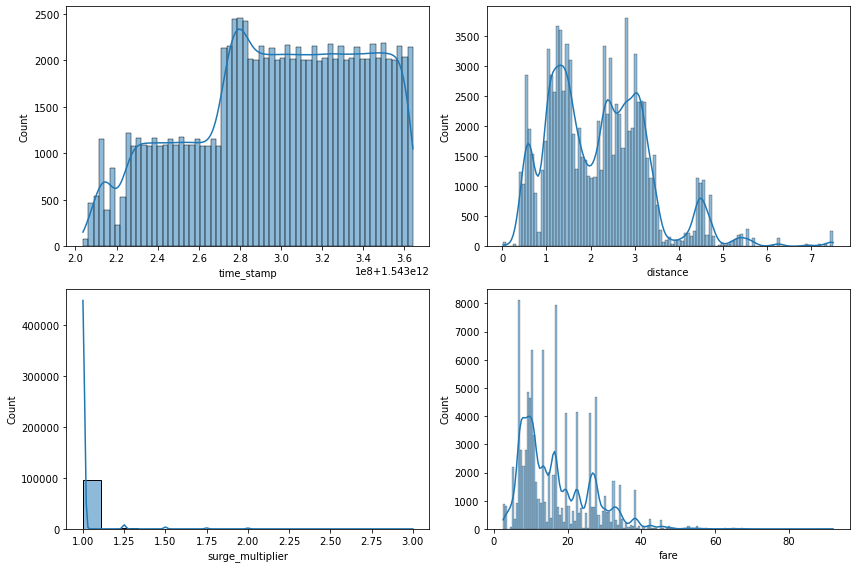

In [9]:
# Figuras
cols=2
rows=2
fig,ax=plt.subplots(figsize=(12,8), nrows=rows,ncols=cols,tight_layout=True)

for i,var in enumerate(numeric.columns):
    sns.histplot(numeric,
                 x=var,
                 kde=True,
                 ax=ax[int(i/rows),(i-cols)])

In [10]:
# Categorical features
categories=train.select_dtypes(include='object')

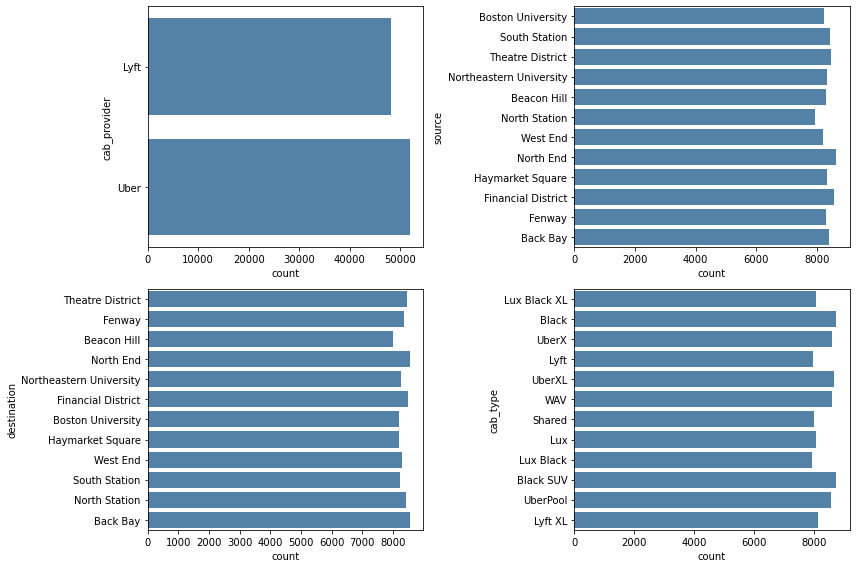

In [11]:
# Figuras
cols=2
rows=2
fig,ax=plt.subplots(figsize=(12,8), nrows=rows,ncols=cols,tight_layout=True)

for i,var in enumerate(categories.columns):
    sns.countplot(data=categories,
                  y=var,
                  color='steelblue',
#                  palette='Blues_r',
                  ax=ax[int(i/rows),(i-cols)])

### 2.2. Análisis multivariable y correlación.

Presentamos en este punto la correlación entre variables numéricas y gráficos de relación entre destino, origen, distancia y tarifa.

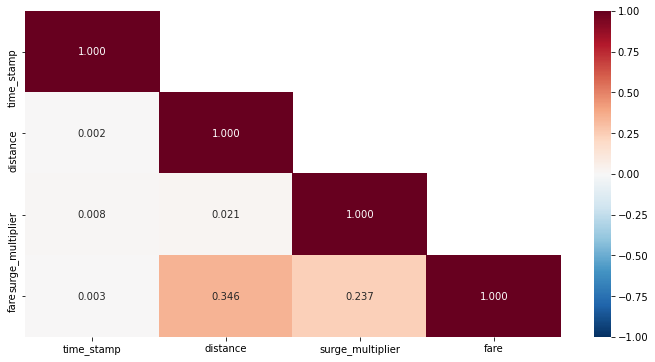

In [12]:

# Matriz de correlación de las variables numéricas
#---------------------------------------------------------------------------
fig, axes = plt.subplots(figsize=(12, 6))

sns.heatmap(train.corr(),
           vmin=-1.0,
           vmax=1.0,
           annot=True, fmt='.3f',
           mask=np.tri(len(train.corr()),len(train.corr()),k=-1,dtype=bool).T,
           cmap='RdBu_r');

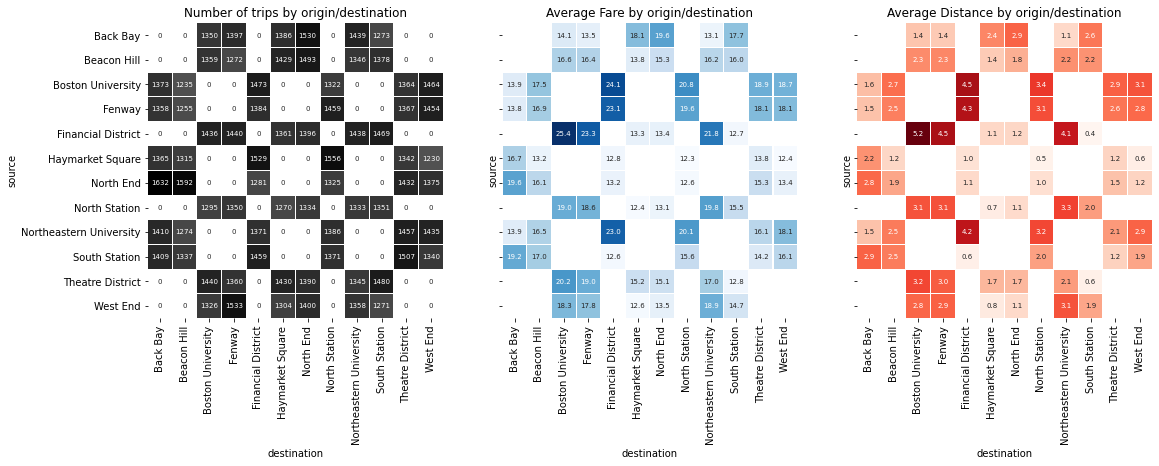

In [13]:
fig, (ax1,ax2,ax3)=plt.subplots(figsize=(18,6), ncols=3,nrows=1, sharey=True)

# Number of trips
sns.heatmap(pd.crosstab(index=train.source,columns=train.destination),
            cmap='Greys',
            annot=True, fmt='d',annot_kws={"size": 7},
            square=True,
            cbar=False,
            linewidth=0.05,
            ax=ax1)

ax1.set_title('Number of trips by origin/destination');

# Fare
sns.heatmap(pd.crosstab(index=train.source,columns=train.destination, values=train.fare, aggfunc='mean'),
            cmap='Blues',
            annot=True, fmt='.1f',annot_kws={"size": 7}, 
            square=True,
            cbar=False,
            linewidth=0.05,
            ax=ax2)


ax2.set_title('Average Fare by origin/destination')

# Distance
sns.heatmap(pd.crosstab(index=train.source,columns=train.destination, values=train.distance, aggfunc='mean'),
            cmap='Reds',
            annot=True, fmt='.1f',annot_kws={"size": 7},
            square=True,
            cbar=False,
            linewidth=0.05,
            ax=ax3)

ax3.set_title('Average Distance by origin/destination');

## 3. Preparación de la muestra para regresión.

Como dije al principio trabajaré con una muestra del 10%.

In [14]:
# Muestreo
muestra=train.sample(n=10000,random_state=1987)

In [15]:
# Features = X / Target = y
y=muestra.fare
X=muestra[['time_stamp','cab_provider','source','destination',
           'distance','surge_multiplier','cab_type']].copy()

### 3.1. Encoding de las variables categóricas.

In [16]:
# Cab provider Encoding
codes={'Uber':0,'Lyft':1}
X.cab_provider=X.cab_provider.map(codes)

# Frecuency encoding for categorical features
for feature in X.select_dtypes(include=object).columns.to_list():
    X[feature]=X[feature].map(X.groupby(feature).size()/len(X)*100)

### 3.2. Modelado de la Pipeline y entrenamiento.

El flujo de trabajo que voy a aplicar en el proceso es el siguiente:
1. Instancio el modelo. En este caso el modelo consistirá en un randomforest. Si además quisiera incluir algún otro proceso tendría que usar la clase Pipeline con los pasos que aplicaremos en el modelo.
2. Definición de la red de parámetros.
3. Definición de las red de ajuste de hiperparámetros.

In [17]:
# Instantiating model
rf_reg=RandomForestRegressor()

# Hyper-parameters tunning-grid
rf_grid={'n_estimators':[100,125,150],
         'max_features':[None],
         'min_samples_leaf':[10,20,30],
         'max_depth':[None,10,15],
          }

# Grid Search CV
rf_GSCV=GridSearchCV(estimator=rf_reg,
                     param_grid=rf_grid,
                     verbose=2,
                     cv=10,
                     n_jobs=-2,
                     scoring='neg_root_mean_squared_error')


In [18]:
# Entrenamiento del modelo
rf_GSCV.fit(X,y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-2,
             param_grid={'max_depth': [None, 10, 15], 'max_features': [None],
                         'min_samples_leaf': [10, 20, 30],
                         'n_estimators': [100, 125, 150]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [19]:
# Medor puntuación
rf_GSCV.best_score_

-2.032739085986052

In [20]:
# Mejor estimador
rf_GSCV.best_estimator_

RandomForestRegressor(max_features=None, min_samples_leaf=10, n_estimators=150)

In [21]:
# Saving model
dump(rf_GSCV.best_estimator_,'./datasets/rf_GSCV.joblib')

['./datasets/rf_GSCV.joblib']

## Exercici 2

Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules



## 1. Carga del archivo de texto.

Para este ejercicio vamos a analizar el discurso de la victoria de Barak Obama en noviembre de 2008. Lo puedes leer en este [enlace].

[enlace]: https://www.independent.co.uk/news/world/americas/the-full-text-of-barack-obama-s-victory-speech-993008.html

In [22]:
discurso=[]
with open ('./datasets/obama.txt',mode='r') as archivo:
    lineas=archivo.readlines()
    for linea in lineas:
        discurso.append(linea.strip())


In [23]:
# Archivo de texto discurso / minusculas
discurso_txt=' '.join(discurso).lower().replace('"','')

In [24]:
print(discurso_txt)

hello, chicago.  if there is anyone out there who still doubts that america is a place where all things are possible, who still wonders if the dream of our founders is alive in our time, who still questions the power of our democracy, tonight is your answer.  it's the answer told by lines that stretched around schools and churches in numbers this nation has never seen, by people who waited three hours and four hours, many for the first time in their lives, because they believed that this time must be different, that their voices could be that difference.  it's the answer spoken by young and old, rich and poor, democrat and republican, black, white, hispanic, asian, native american, gay, straight, disabled and not disabled, americans who sent a message to the world that we have never been just a collection of individuals or a collection of red states and blue states.  we are, and always will be, the united states of america.  it's the answer that led those who've been told for so long b

## 2. Tokenización.
La librería NLTK tiene diferentes métodos para convertir el texto a tokens. Veamos algunos de esos métodos:

- sent_tokenize(texto) - Divide las frases del parrafo.
- word_tokenize(texto) - Separa palabras en una frase.
- TreeBankTokenizer
- WordPuncTokenizer
- RegexpTokenizer o regexp_tokenize - Que obtienen los tokens en función a patrones de expresiones Regex.

In [25]:
from nltk.tokenize import sent_tokenize,word_tokenize, WordPunctTokenizer, regexp_tokenize

In [26]:
# Tokens del discurso
discurso_tokens=word_tokenize(discurso_txt)
print(discurso_tokens[:50])

['hello', ',', 'chicago', '.', 'if', 'there', 'is', 'anyone', 'out', 'there', 'who', 'still', 'doubts', 'that', 'america', 'is', 'a', 'place', 'where', 'all', 'things', 'are', 'possible', ',', 'who', 'still', 'wonders', 'if', 'the', 'dream', 'of', 'our', 'founders', 'is', 'alive', 'in', 'our', 'time', ',', 'who', 'still', 'questions', 'the', 'power', 'of', 'our', 'democracy', ',', 'tonight', 'is']


In [27]:
# Tokens del discurso
wpt=WordPunctTokenizer()
discurso_tokens_wpt=wpt.tokenize(discurso_txt)
print(discurso_tokens_wpt[:50])

['hello', ',', 'chicago', '.', 'if', 'there', 'is', 'anyone', 'out', 'there', 'who', 'still', 'doubts', 'that', 'america', 'is', 'a', 'place', 'where', 'all', 'things', 'are', 'possible', ',', 'who', 'still', 'wonders', 'if', 'the', 'dream', 'of', 'our', 'founders', 'is', 'alive', 'in', 'our', 'time', ',', 'who', 'still', 'questions', 'the', 'power', 'of', 'our', 'democracy', ',', 'tonight', 'is']


In [28]:
# Tokens del discurso  
discurso_tokens_regex=regexp_tokenize(discurso_txt,"[\w']+")
print(discurso_tokens_regex[:50])

['hello', 'chicago', 'if', 'there', 'is', 'anyone', 'out', 'there', 'who', 'still', 'doubts', 'that', 'america', 'is', 'a', 'place', 'where', 'all', 'things', 'are', 'possible', 'who', 'still', 'wonders', 'if', 'the', 'dream', 'of', 'our', 'founders', 'is', 'alive', 'in', 'our', 'time', 'who', 'still', 'questions', 'the', 'power', 'of', 'our', 'democracy', 'tonight', 'is', 'your', 'answer', "it's", 'the', 'answer']


Vemos que word_tokenize y WordPunctTokenizer separan las palabras de manera similar, manteniendo los símbolos de puntuación. En el caso de regexp_tokenize he introducido una sentencia regex que capture palabras y contracciones (_it's, can't, etc._) 

### 2.1. Frecuencia de aparición de los tokens.

Con la función FreqDist se puede calcular fácilmente las palabras más aparecidas en un texto. Veamoslo.

In [29]:
from nltk.probability import FreqDist

In [30]:
fdist=FreqDist(discurso_tokens)

In [31]:
print(fdist.most_common(50))

[(',', 116), ('the', 109), ('.', 105), ('and', 89), ('of', 60), ('to', 60), ('we', 46), ('that', 43), ('a', 42), ('in', 34), ('i', 31), ('this', 29), ('who', 28), ('for', 27), ('our', 26), ("'s", 25), ('you', 22), ('it', 20), ('will', 18), ('can', 17), ('there', 15), ('is', 15), ('america', 15), ('not', 15), ('with', 15), ('tonight', 14), ('be', 14), ('are', 13), ('on', 13), ('people', 12), ('have', 12), ('from', 12), ('us', 12), ('my', 12), ('new', 12), ('by', 11), ('their', 11), ('so', 11), ('but', 11), ('she', 11), ('was', 11), ('all', 10), ('those', 10), ('as', 10), ('or', 9), ('what', 9), (';', 9), ("n't", 9), ('nation', 8), (':', 8)]


De manera más gráfica:

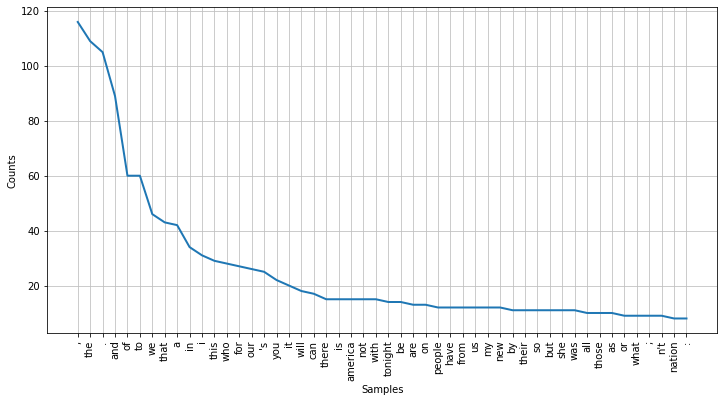

In [32]:
plt.subplots(figsize=(12,6))
fdist.plot(50,cumulative=False)
plt.show();

Si calculo la distribución de palabras para los tokens obtenidos con la expresión regex, veo que la principal diferencia es que con el método regex no he obtenido los signos de puntuación.

In [33]:
fdist_regex=FreqDist(discurso_tokens_regex)
print(fdist_regex.most_common(70))

[('the', 109), ('and', 89), ('of', 60), ('to', 60), ('we', 45), ('a', 42), ('that', 40), ('in', 34), ('i', 31), ('this', 29), ('for', 27), ('who', 26), ('our', 26), ('you', 20), ('will', 18), ('is', 15), ('with', 15), ('there', 14), ('america', 14), ('be', 14), ('it', 14), ('are', 13), ('tonight', 13), ('can', 13), ('on', 13), ('people', 12), ('not', 12), ('have', 12), ('so', 12), ('from', 12), ('us', 12), ('my', 12), ('new', 12), ('by', 11), ('their', 11), ('but', 11), ('was', 11), ('all', 10), ('those', 10), ('as', 10), ('or', 9), ('what', 9), ('she', 8), ('if', 7), ('time', 7), ('many', 7), ('more', 7), ('know', 7), ('one', 7), ('yes', 7), ('your', 6), ("it's", 6), ('nation', 6), ('has', 6), ('because', 6), ('been', 6), ('states', 6), ('long', 6), ('change', 6), ('campaign', 6), ('when', 6), ('her', 6), ('answer', 5), ('told', 5), ('never', 5), ('world', 5), ('hope', 5), ('election', 5), ('them', 5), ('best', 5)]


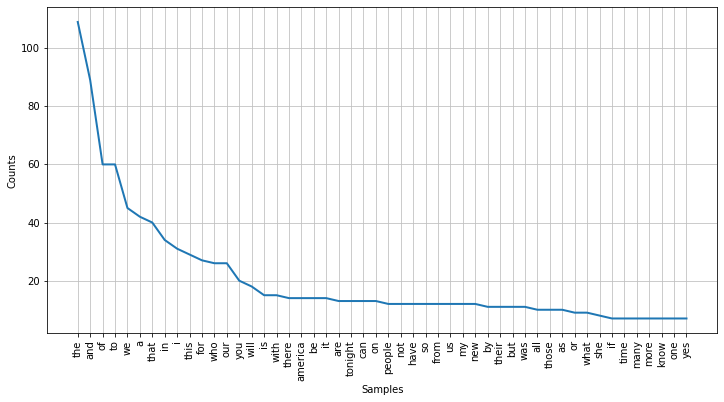

In [34]:
# Plot freq_dist
plt.subplots(figsize=(12,6))
fdist_regex.plot(50,cumulative=False)
plt.show();

Si analizamor las 50 palabras más empleadas por Obama en su discurso, vemos que hay numerosos palabras comunes como pronombres, artículos, conjunciones, etc. Vamos a filtrar esas palabras que no aportan información sobre el texto utilizando el concepto de stopwords.

# Nivell 2
## Exercici 1

Treu les stopwords i realitza stemming al teu conjunt de dades.


### 2.2. Filtrando stopwords.

In [35]:
from nltk.corpus import stopwords

In [36]:
# Colección stopwords en inglés
stop_words=set(stopwords.words('english'))
print(stop_words)

{'will', 'can', "don't", 'on', 'itself', 'then', 'than', "didn't", 'what', 'ma', 'own', 'am', "needn't", 'has', 'your', 'don', 'being', 'theirs', 'did', 'in', 'below', 'me', 'are', "mightn't", 'our', 'same', 'few', 'with', 'ours', 'her', 'so', 'very', 'he', 'an', 'here', "haven't", "wouldn't", 'both', 'been', 'to', 'do', 'she', 'only', 's', 've', 'most', 'too', 'is', 'between', 'when', 'not', 'his', 'hadn', 'just', 'were', 'him', 'herself', 'yours', 'needn', 'doesn', 'up', 'the', 'each', 'll', 'hasn', "that'll", 'mustn', "hasn't", 'more', 'out', "she's", 'who', 'o', 'be', 'yourself', 'if', 'have', "hadn't", "shan't", 'at', "shouldn't", "weren't", 'i', 'couldn', 'm', 're', 'again', 'but', 'all', "it's", 'was', 'its', 'why', 'whom', "you're", 'it', "you've", 'further', 't', 'once', "doesn't", 'we', 'my', 'until', "isn't", 'a', 'themselves', 'this', 'while', 'these', 'any', 'should', 'as', 'mightn', 'weren', 'where', 'no', 'himself', 'they', 'now', 'from', "couldn't", "won't", 'down', 'th

In [37]:
discurso_filtered=[]

for word in discurso_tokens:
    if word not in stop_words:
        discurso_filtered.append(word)

In [38]:
FreqDist(discurso_filtered)

FreqDist({',': 116, '.': 105, "'s": 25, 'america': 15, 'tonight': 14, 'people': 12, 'us': 12, 'new': 12, ';': 9, "n't": 9, ...})

Como vemos seguimos teniendo el problema de la puntuación y de las contracciones, si quieremos limpiar la lista, tendría que añadir a las stop words los simbolos de puntuación y las contracciones 's o n't.

In [39]:
import string
puntuacion=string.punctuation
puntuacion

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
#Lista con los elementos a eliminar de la lista de tokens
elementos_a_eliminar=[elemento for elemento in puntuacion]+["'s","n't","'ve"]+list(stop_words)

In [41]:
discurso_filtered_ok=[word for word in discurso_tokens if word not in elementos_a_eliminar]
FreqDist(discurso_filtered_ok)

FreqDist({'america': 15, 'tonight': 14, 'people': 12, 'us': 12, 'new': 12, 'nation': 8, 'time': 7, 'many': 7, 'know': 7, 'one': 7, ...})

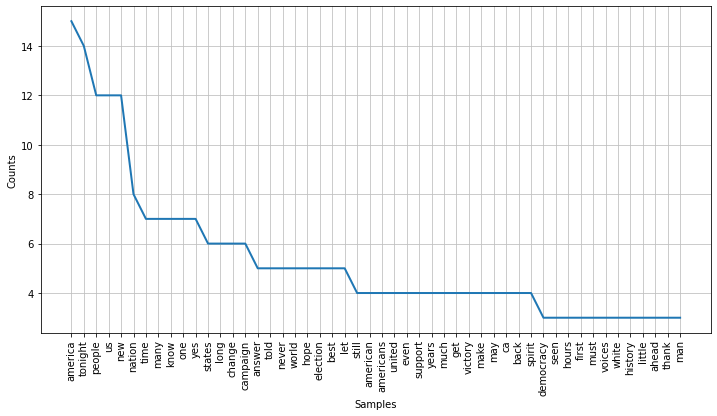

In [42]:
plt.subplots(figsize=(12,6))
FreqDist(discurso_filtered_ok).plot(50,cumulative=False)
plt.show();

En el caso de la lista de tokens extraida con nuestra expresion regular, la lista de las 50 tokens más habituales queda como:

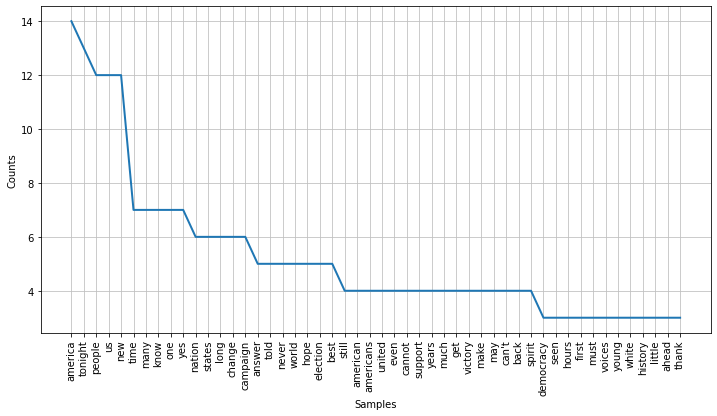

In [43]:
discurso_regex_filtered_ok=[word for word in discurso_tokens_regex if word not in stop_words]
plt.subplots(figsize=(12,6))
FreqDist(discurso_regex_filtered_ok).plot(50,cumulative=False)
plt.show();

### 2.3. Estemizando y lematizando nuestra lista de tokens.

Stemming es un método para reducir una palabra a su raíz (stem en inglés) eliminando sufijos y prefijos.

Por otro lado, lematización es una técnica similar a stemming, donde el resultado es un lema, que es la palabra raiz que por convenio se acepta como representante de todas las formas flexionadas de la misma.

Veamos como se aplica.

**Stemming**

In [44]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag

In [45]:
# Stemming con Porter Stemmer
ps=PorterStemmer()
discurso_stemmed=[]

for palabra in discurso_filtered_ok:
    discurso_stemmed.append(ps.stem(palabra))

In [46]:
print(FreqDist(discurso_stemmed).most_common(50))

[('america', 15), ('tonight', 14), ('peopl', 12), ('us', 12), ('new', 12), ('time', 9), ('nation', 9), ('american', 8), ('know', 8), ('mani', 7), ('state', 7), ('hope', 7), ('campaign', 7), ('one', 7), ('ye', 7), ('live', 6), ('long', 6), ('chang', 6), ('year', 6), ('answer', 5), ('told', 5), ('never', 5), ('world', 5), ('come', 5), ('elect', 5), ('even', 5), ('work', 5), ('best', 5), ('let', 5), ('still', 4), ('first', 4), ('voic', 4), ('unit', 4), ('achiev', 4), ('hand', 4), ('support', 4), ('much', 4), ('get', 4), ('victori', 4), ('gener', 4), ('centuri', 4), ('make', 4), ('may', 4), ('ca', 4), ('back', 4), ('spirit', 4), ('doubt', 3), ('thing', 3), ('wonder', 3), ('democraci', 3)]


**Lemmatization**

Para conseguir una lematización más precisa deberíamos informar del tipo de palabra que queremos lematizar. para conseguir esto podemos utilizar una técnica conocida como POS tagging (part of speech tagging).

In [47]:


# Instancia lemmatizer
lemma=WordNetLemmatizer()

# Diccionario POS_TAG - tag lemmatizer
tagger={'N':'n','V':'v','R':'r','JJ':'a'}

Pos_discurso_filtered_ok=pos_tag(discurso_filtered_ok)

# Para cada lemma informamos al lemmatizer la palabra y part of speech tag
discurso_lemma_pos=[lemma.lemmatize(w,tagger[t[0]]) if t[0] in tagger else lemma.lemmatize(w) for w,t in Pos_discurso_filtered_ok ]

print(FreqDist(discurso_lemma_pos).most_common(50))

[('america', 15), ('tonight', 14), ('people', 12), ('u', 12), ('new', 12), ('time', 9), ('nation', 8), ('american', 8), ('know', 8), ('many', 7), ('state', 7), ('campaign', 7), ('make', 7), ('one', 7), ('yes', 7), ('tell', 6), ('see', 6), ('live', 6), ('long', 6), ('hope', 6), ('come', 6), ('change', 6), ('year', 6), ('answer', 5), ('never', 5), ('world', 5), ('election', 5), ('even', 5), ('work', 5), ('woman', 5), ('best', 5), ('let', 5), ('still', 4), ('first', 4), ('voice', 4), ('achieve', 4), ('hand', 4), ('stand', 4), ('support', 4), ('much', 4), ('get', 4), ('victory', 4), ('generation', 4), ('century', 4), ('may', 4), ('ca', 4), ('back', 4), ('spirit', 4), ('thing', 3), ('wonder', 3)]


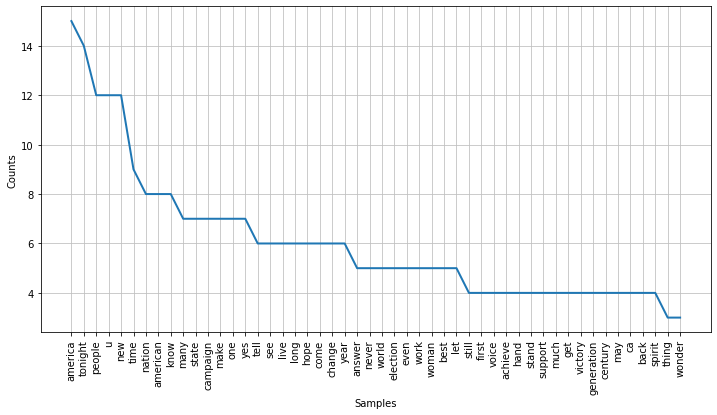

In [48]:
plt.subplots(figsize=(12,6))
FreqDist(discurso_lemma_pos).plot(50,cumulative=False)
plt.show()


# Nivell 3
## Exercici 1

Realitza sentiment analysis al teu conjunt de dades.


## 3. Análisis de sentimientos.

Para el análisis de sentimientos voy a utilizar dos librerías diferentes, VADER y TEXTBLOB.

**Analísis de sentimientos con VADER**


VADER ( Valence Aware Dictionary and sEntiment Reasoner ) es una herramienta de análisis de sentimientos basada en reglas y léxico. De un algoritmo pre entrenado que etiqueta las palabras de acuerdo con su orientación semántica como positiva o negativa. VADER devuelve las puntuación positiva, negativa y neutra y una métrica llamada COMPOUND que es una composición de los tres sentimientos anteriores. 

Valores de compound mayores de 0.5 nos indican sentimientos positivos, entre -0.5 y 0.5 sentimientos neutros y sentimientos negativos para valores inferiores a -0.5.



In [49]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

In [50]:
vader_analyzer=SentimentIntensityAnalyzer()

In [51]:
vader_analyzer.polarity_scores(discurso_txt)

{'neg': 0.073, 'neu': 0.749, 'pos': 0.178, 'compound': 0.9998}

VADER puntua el discurso muy positivo (compound cerca de 1).

Veamos como puntua frase a frase.

In [52]:
sentimen_vader=[]
for m in discurso[::2]:
    sentimen_vader.append((vader_analyzer.polarity_scores(m)))  
    

In [53]:
VADER_df=pd.DataFrame(sentimen_vader,index=discurso[::2])
VADER_df

,neg,neu,pos,compound
"Hello, Chicago.",0.000,1.000,0.000,0.0000
"""If there is anyone out there who still doubts that America is a place where all things are possible, who still wonders if the dream of our founders is alive in our time, who still questions the power of our democracy, tonight is your answer.",0.046,0.858,0.096,0.3400
"""It's the answer told by lines that stretched around schools and churches in numbers this nation has never seen, by people who waited three hours and four hours, many for the first time in their lives, because they believed that this time must be different, that their voices could be that difference.",0.000,1.000,0.000,0.0000
"""It's the answer spoken by young and old, rich and poor, Democrat and Republican, black, white, Hispanic, Asian, Native American, gay, straight, disabled and not disabled, Americans who sent a message to the world that we have never been just a collection of individuals or a collection of red states and blue states.",0.056,0.845,0.099,0.3400
"""We are, and always will be, the United States of America.",0.000,0.781,0.219,0.4215
...,...,...,...,...
"""Yes we can.",0.000,0.426,0.574,0.4019
"""America, we have come so far. We have seen so much. But there is so much more to do. So tonight, let us ask ourselves - if our children should live to see the next century; if my daughters should be so lucky to live as long as Ann Nixon Cooper, what change will they see? What progress will we have made?",0.000,0.897,0.103,0.7767
"""This is our chance to answer that call. This is our moment.",0.000,0.846,0.154,0.2500
"""This is our time, to put our people back to work and open doors of opportunity for our kids; to restore prosperity and promote the cause of peace; to reclaim the American dream and reaffirm that fundamental truth, that, out of many, we are one; that while we breathe, we hope. And where we are met with cynicism and doubts and those who tell us that we can't, we will respond with that timeless creed that sums up the spirit of a people: Yes, we can.",0.048,0.728,0.223,0.9413


In [54]:
VADER_df.mean()

neg         0.050656
neu         0.809377
pos         0.139951
compound    0.290916
dtype: float64

**Análisis de sentimientos con TextBlob**

TextBlob es una librería para procesar datos de texto. TextBlob tiene un módulo de analisis de sentimientos con el que obtenemos una métrica de polaridad y subjetividad. 

La polaridad es el sentimiento mismo, que va de -1 a +1. La subjetividad es una medida del sentimiento siendo objetivo a subjetivo, y va de 0 a 1. Preferimos ver el sentimiento que es objetivo que subjetivo, así que una puntuación más baja probablemente denote una lectura más precisa. Ya veremos.

In [55]:
from textblob import TextBlob

In [56]:
discurso_textblob=TextBlob(discurso_txt)

In [57]:
discurso_textblob.sentiment

Sentiment(polarity=0.14397003119429594, subjectivity=0.43532754010695185)

TextBlob evalua este discurso como neutro, ligeramente positivo y con un grado de subjetividad a tener en cuenta.

Podemos hacer el análisis frase a frase.

In [58]:
sentimen_textblob=[]
for m in discurso[::2]:
    sentimen_textblob.append((TextBlob(m).polarity,TextBlob(m).subjectivity))  
    

In [59]:
TEXTBLOB_df=pd.DataFrame(sentimen_textblob, columns=['Polaridad','Subjetividad'],index=discurso[::2])
TEXTBLOB_df

,Polaridad,Subjetividad
"Hello, Chicago.",0.000000,0.000000
"""If there is anyone out there who still doubts that America is a place where all things are possible, who still wonders if the dream of our founders is alive in our time, who still questions the power of our democracy, tonight is your answer.",0.050000,0.700000
"""It's the answer told by lines that stretched around schools and churches in numbers this nation has never seen, by people who waited three hours and four hours, many for the first time in their lives, because they believed that this time must be different, that their voices could be that difference.",0.175000,0.358333
"""It's the answer spoken by young and old, rich and poor, Democrat and Republican, black, white, Hispanic, Asian, Native American, gay, straight, disabled and not disabled, Americans who sent a message to the world that we have never been just a collection of individuals or a collection of red states and blue states.",0.037500,0.290476
"""We are, and always will be, the United States of America.",0.000000,0.000000
...,...,...
"""Yes we can.",0.000000,0.000000
"""America, we have come so far. We have seen so much. But there is so much more to do. So tonight, let us ask ourselves - if our children should live to see the next century; if my daughters should be so lucky to live as long as Ann Nixon Cooper, what change will they see? What progress will we have made?",0.169508,0.491667
"""This is our chance to answer that call. This is our moment.",0.000000,0.000000
"""This is our time, to put our people back to work and open doors of opportunity for our kids; to restore prosperity and promote the cause of peace; to reclaim the American dream and reaffirm that fundamental truth, that, out of many, we are one; that while we breathe, we hope. And where we are met with cynicism and doubts and those who tell us that we can't, we will respond with that timeless creed that sums up the spirit of a people: Yes, we can.",0.125000,0.250000


In [60]:
TEXTBLOB_df.mean()

Polaridad       0.133329
Subjetividad    0.312431
dtype: float64

**Conclusiones**

Cuando analizamos con Vader el discurso entero, el modelo le da una puntuación de compound muy alta, donde lo que más pesa es el sentimiento nuetro. Si descomponemos el discurso frase a frase la valoración media de neutralidad sigue siendo el valor predominante.

Con textblob obtenemos valores de polaridad alrededor de 0,14 y con una subjetividad del 0,4.

Como vemos ambos modelos asignan un tono neutro del discurso tirando más hacia positivo y en ningún caso detectan sentimientos negativos.

Por último hay que tener en cuenta que estos modelos han sido entrenados para analizar comentarios de redes sociales como tweeter o facebook, donde los te